In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2024-05-16 09:02:18--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-05-16 09:02:18 (42.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/fcd3a71/releases/pybind11-inst

**Exercice *3*.**
Solve the Stokes equations with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega \\
u &= u_{input} \quad && \text{on } \Gamma_{input} \\
\sigma\cdot n &= (0, 0) \quad && \text {on } \Gamma_{output} \\
p &= p_{output} \quad && \text {on } \Gamma_{output} \\
u &= (0,0) \quad && \text{on } \Gamma_0 \\
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.

This is a model of linear (creeping) flow in the idealized case of infinitesimal (small) velocities.

We will use the following data:

* The domain $\Omega$ is shown in the following figure:

* $f = (0,0)$
* $\Gamma_{output} = \{(x,y) \in \partial\Omega \,\vert\, x = 4\}$ (the right boundary)
* $\Gamma_{input} = \{(x,y) \in \partial\Omega \,\vert\, x = -2\}$ (the left boundary)
* $\Gamma_{0} = \partial\Omega \setminus (\Gamma_{input} \cup \Gamma_{output})$ (no-slip boundary condition)
* $p_{output} = 0$ (outflow)
* $u_{input} = \left(1.5 \cdot \frac{6y(-2 - y)}{7}, 0\right)$ (inflow)
* $\mu = 0.01$ (dynamic viscosity)

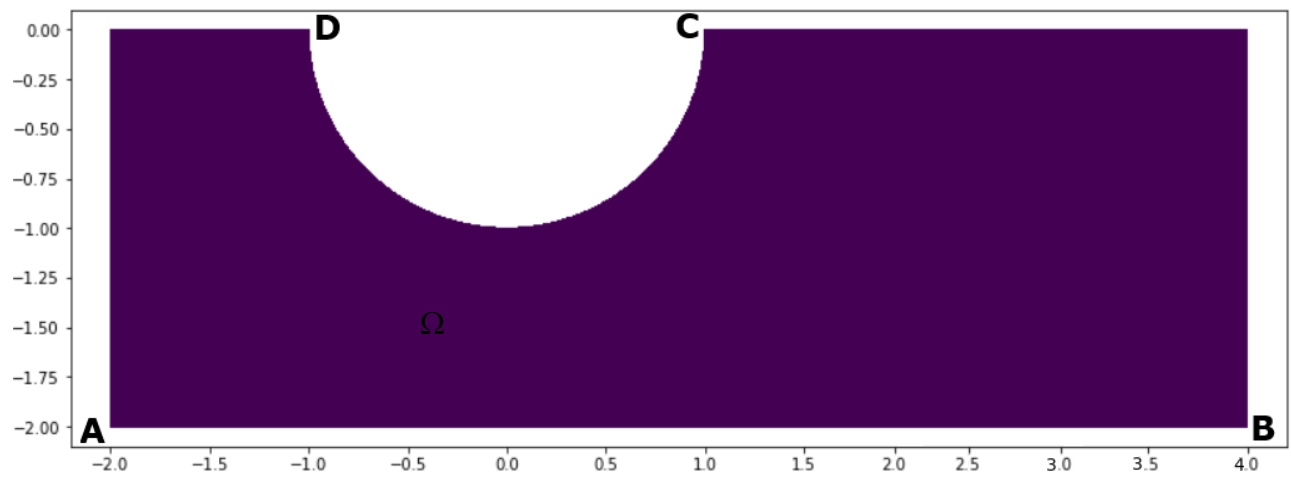

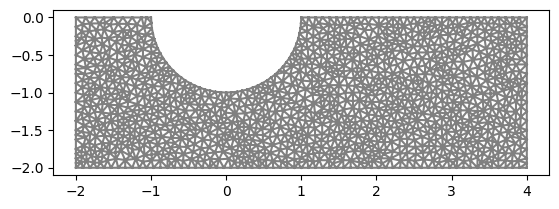

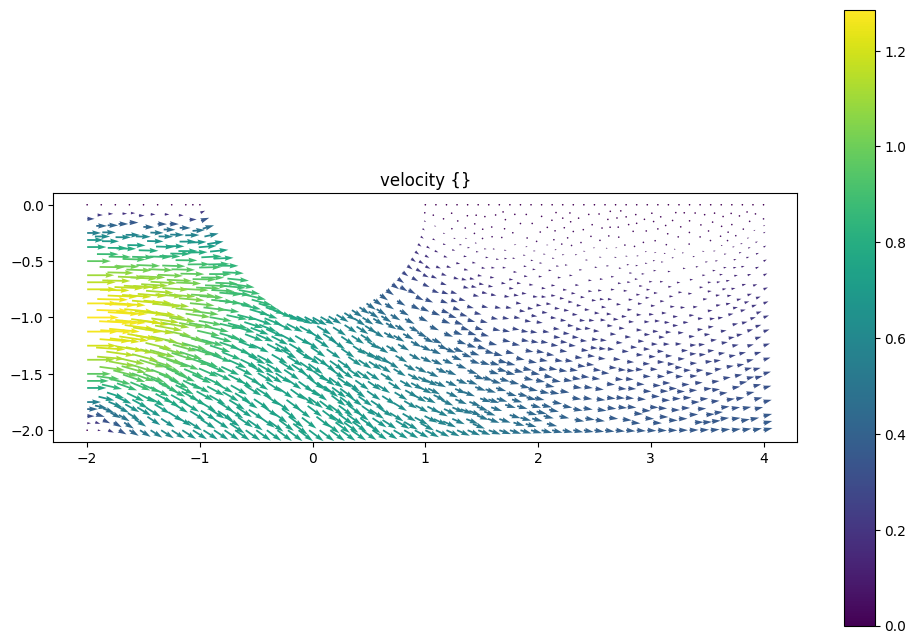

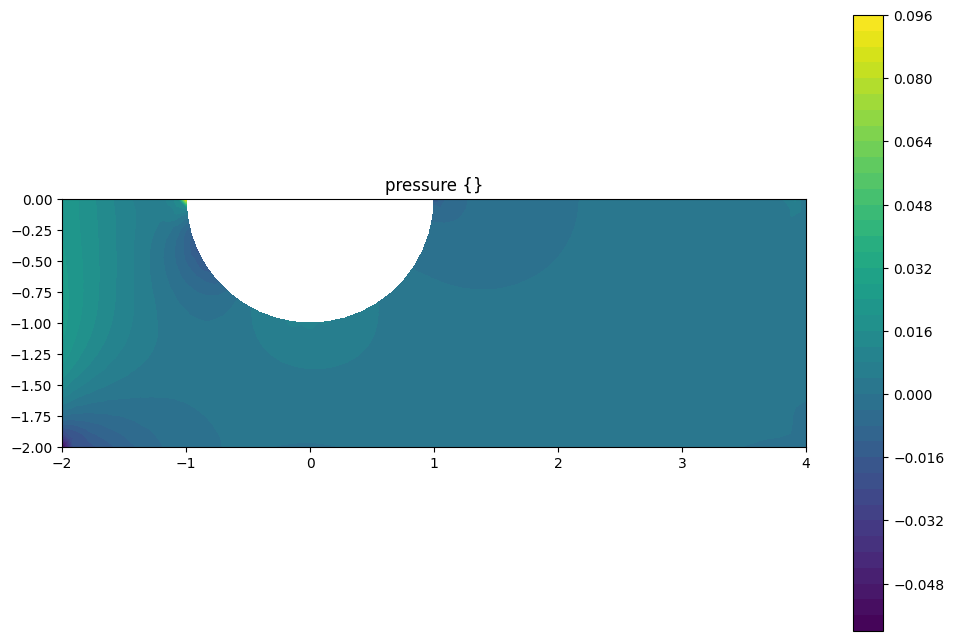

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

%matplotlib inline
L,L2,R = 4., 0.,1.
N = 40 # mesh density

domain = Rectangle(Point(-2.,-2.), Point(L, L2)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh)

# Problem data
#u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),degree=2, U=1.5)
p_L = Constant(0)
u_in = Expression(('1.5*6.0*x[1]*(-2.0 - x[1]) / 7.0', '0.0'), degree=2)
mu = Constant(0.01)

# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
class Walls(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return (on_boundary and abs(x[1]) < tol) or (on_boundary and abs(x[1]- 2) < tol)

walls = Walls()

# inflow
class Inflow(SubDomain):
  def inside(self, x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]+2) < tol

inflow = Inflow()

# outflow
class Outflow(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]-L) < tol
outflow = Outflow()

# cylinder
class Cylinder(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs((x[0])**2 + (x[1])**2 - R**2) < tol
cylinder = Cylinder()


bndry.set_all(0)

inflow.mark(bndry, 1)
outflow.mark(bndry, 2)
walls.mark(bndry, 3)
cylinder.mark(bndry, 5)


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc_walls = DirichletBC(W.sub(0), (0, 0), bndry, 3)
bc_cylinder = DirichletBC(W.sub(0), (0, 0), bndry, 5)
# The inflow velocity
bc_in = DirichletBC(W.sub(0), u_in, bndry, 1)
# The outflow pressure
bc_out = DirichletBC(W.sub(1), p_L, bndry, 2)

bcs = [bc_cylinder, bc_walls, bc_in, bc_out]

# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)